## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Import Library

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms

import time

import random
random.seed(777)

## GPU Setting

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

print(f'Using PyTorch version: {torch.__version__} / Device: {device}')

Using PyTorch version: 1.8.1+cu101 / Device: cuda


## Hyperparameters

In [ ]:
TRAINPATH = 'drive/MyDrive/Capstone-Design/dataset/AIHub/train' 
SAVEPATH = 'drive/MyDrive/Capstone-Design/model/AIHub/ResNet'

LOADEPOCH = 100
ACC = 91

LR = 0.01
MOMENTUM = 0.9
WEIGHTDECAY = 5e-4

EPOCHS = 100
STEPSIZE = 30
GAMMA = 0.1

BATCHSIZE = 32

PRINTFREQ = 10

## Data Load

In [ ]:
transfrom_train = transforms.Compose([
                            # transforms.RandomCrop(32, padding=4),
                            # transforms.RandomResizedCrop(224),
                            transforms.Resize(224),
                            transforms.RandomHorizontalFlip(),
                            transforms.RandomRotation(10),
                            transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])

# transform_test = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(), 
#     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
# ])

train_dataset = torchvision.datasets.ImageFolder(root=TRAINPATH, transform=transfrom_train)

train_len = int((8/10) * len(train_dataset))
valid_len = len(train_dataset) - train_len

torch.manual_seed(777)
train_data, valid_data = torch.utils.data.dataset.random_split(train_dataset, [train_len, valid_len])

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCHSIZE, shuffle=True, num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=BATCHSIZE, shuffle=False, num_workers=2)

# test_data = torchvision.datasets.ImageFolder(root=TESTPATH, transform=transform_test)
# test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCHSIZE, shuffle=False, num_workers=2)


classes = ('궤양병', '잎곰팡이병', '점무늬병', '황화잎말림바이러스', '아메리카잎굴파리', '청벌레', '정상')

In [ ]:
len(train_data.dataset.samples)

14955

In [ ]:
len(valid_data)

2991

In [ ]:
print('train :', len(train_data))
print('valid :', len(valid_data))

train : 11964
valid : 2991


## Define Model

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes) #conv1x1(64,64)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes, stride) #conv3x3(64,64)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion) #conv1x1(64,256)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x) # 1x1 stride = 1
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out) # 3x3 stride = stride 
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out) # 1x1 stride = 1
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=False):
        super(ResNet, self).__init__()

        self.inplanes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
model = ResNet(Bottleneck, [3, 4, 6, 3], 7, True).to(device)

## Load Model

In [ ]:
if LOADEPOCH != 0:
  model.load_state_dict(torch.load(f'{SAVEPATH}/model_epoch_{LOADEPOCH}_acc_{ACC}.pth'))
  # model.eval()
  print(f'Load Model: model_epoch_{LOADEPOCH}_acc_{ACC}')
else:
  print('New Model')

Load Model: model_epoch_100_acc_91


In [ ]:
# test model
a=torch.Tensor(1,3,244,244).to(device)
out = model(a)
print(out)

tensor([[nan, nan, nan, nan, nan, nan, nan]], device='cuda:0',
       grad_fn=<AddmmBackward>)


## Train Model

In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHTDECAY)
lr_sche = optim.lr_scheduler.StepLR(optimizer, step_size=STEPSIZE, gamma=GAMMA)

In [ ]:
def acc_check(net, test_set, epoch, save=1):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_set:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    acc = (100 * correct / total)
    print(f'Accuracy of the network on the {len(valid_data)} test images: {acc:.2f} %')
    if save:
        torch.save(net.state_dict(), SAVEPATH + "/model_epoch_{}_acc_{}.pth".format(epoch, int(acc)))
    return acc

In [ ]:
print(len(train_loader))
print('Start training')

valid_accuracy = []
valid_loss = []

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    print(f"======================[Epoch {epoch+1:2d}]======================")

    running_loss = 0.0
    lr_sche.step()

    if epoch < LOADEPOCH:
      continue

    for i, data in enumerate(train_loader, 0):
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i + 1) % PRINTFREQ == 0:
            print('[%3d, %4d] loss: %.3f' % (epoch+1, i+1, running_loss / PRINTFREQ))
            running_loss = 0.0
    
    #Check Accuracy
    acc = acc_check(model, valid_loader, epoch+1, save=1)
    valid_accuracy.append(acc)
    valid_loss.append(loss.item())
    

print('Finished Training')

374
Start training
======================[Epoch  1]======================


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


[  1,   10] loss: 1.410
[  1,   20] loss: 0.971
[  1,   30] loss: 1.138
[  1,   40] loss: 0.913
[  1,   50] loss: 0.877
[  1,   60] loss: 0.894
[  1,   70] loss: 1.140
[  1,   80] loss: 1.075
[  1,   90] loss: 0.666
[  1,  100] loss: 0.869
[  1,  110] loss: 0.834
[  1,  120] loss: 0.842
[  1,  130] loss: 0.836
[  1,  140] loss: 0.919
[  1,  150] loss: 0.730
[  1,  160] loss: 0.798
[  1,  170] loss: 0.805
[  1,  180] loss: 0.705
[  1,  190] loss: 0.884
[  1,  200] loss: 0.861
[  1,  210] loss: 0.841
[  1,  220] loss: 0.863
[  1,  230] loss: 0.905
[  1,  240] loss: 0.677
[  1,  250] loss: 0.813
[  1,  260] loss: 0.713
[  1,  270] loss: 0.963
[  1,  280] loss: 0.687
[  1,  290] loss: 0.763
[  1,  300] loss: 1.139
[  1,  310] loss: 1.020
[  1,  320] loss: 1.086
[  1,  330] loss: 0.889
[  1,  340] loss: 0.716
[  1,  350] loss: 0.725
[  1,  360] loss: 0.763
[  1,  370] loss: 0.748
Accuracy of the network on the 2991 test images: 78.07 %
======================[Epoch  2]======================


## Test Model

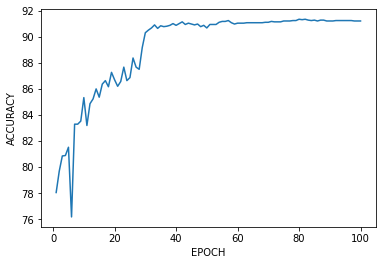

In [ ]:
import matplotlib.pyplot as plt

epochs = [i for i in range(1, 101)]

plt.plot(epochs, valid_accuracy)
plt.xlabel('EPOCH')
plt.ylabel('ACCURACY')
plt.show()

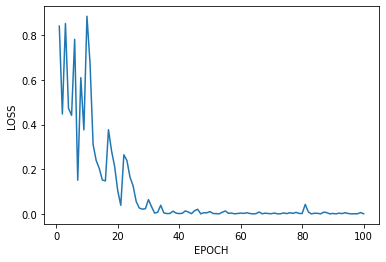

In [ ]:
plt.plot(epochs, valid_loss)
plt.xlabel('EPOCH')
plt.ylabel('LOSS')
plt.show()

In [ ]:
class_correct = list(0. for i in range(7))
class_total = list(0. for i in range(7))
with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(7):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   궤양병 : 76 %
Accuracy of 잎곰팡이병 : 80 %
Accuracy of  점무늬병 : 84 %
Accuracy of 황화잎말림바이러스 : 81 %
Accuracy of 아메리카잎굴파리 : 88 %
Accuracy of   청벌레 : 37 %
Accuracy of    정상 : 97 %


In [ ]:
data = valid_loader

In [ ]:
correct = 0
total = 0

with torch.no_grad():
    for data in valid_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predicted = torch.max(outputs.data, 1)
        ls = []
        print(labels[0]==0, predicted[0])
        ls.append(labels[0])
        print(ls)
        total += labels.size(0)
        
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(valid_data)} test images: {(100 * correct)/total:.2f} %')

tensor(False, device='cuda:0') tensor(4, device='cuda:0')
[tensor(4, device='cuda:0')]
tensor(False, device='cuda:0') tensor(2, device='cuda:0')
[tensor(2, device='cuda:0')]
tensor(False, device='cuda:0') tensor(6, device='cuda:0')
[tensor(6, device='cuda:0')]
tensor(False, device='cuda:0') tensor(6, device='cuda:0')
[tensor(6, device='cuda:0')]
tensor(False, device='cuda:0') tensor(6, device='cuda:0')
[tensor(2, device='cuda:0')]
tensor(False, device='cuda:0') tensor(3, device='cuda:0')
[tensor(2, device='cuda:0')]


KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

GroundTruth: 
 아메리카잎굴파리 
    정상 
 아메리카잎굴파리 
 잎곰팡이병 
  점무늬병 
    정상 
 아메리카잎굴파리 



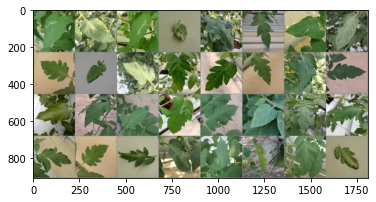

In [ ]:
dataiter = iter(valid_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: \n', ' '.join('%5s \n' % classes[labels[j]] for j in range(7)))

In [ ]:
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: \n', ' '.join('%5s \n' % classes[predicted[j]] for j in range(7)))

Predicted: 
 아메리카잎굴파리 
    정상 
 아메리카잎굴파리 
 잎곰팡이병 
    정상 
    정상 
 아메리카잎굴파리 

